In [1]:
# Modules import
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split


In [2]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [3]:
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "Combined Data.csv"))

100%|██████████| 11.1M/11.1M [00:00<00:00, 51.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [4]:
# eliminate rows that don't have text to work with
df = df.loc[df.statement.isna() == False]

In [5]:
# Function to plot the Histogram of the classes
def print_class_histogram(df, text="", ax=None):
    class_totals = pd.concat([df.status.value_counts(), df.status.value_counts(normalize=True)], axis = 1)
    class_totals.columns = ["total", "percentage"]
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (10,5))
    class_totals.total.plot(kind = "bar", title = text + " Histogram ", ax=ax)
    ax.set_xticklabels(class_totals.index, rotation = 0)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for p in np.arange(len(class_totals.percentage.values)):
        ax.annotate(str(round(class_totals.percentage.values[p]*100,1)) + "%", (p, 100) , ha = 'center', color = "white")
        ax.annotate(f"{class_totals.total.values[p]:,}", (p, 1000) , ha = 'center', color = "Black")
    return ax

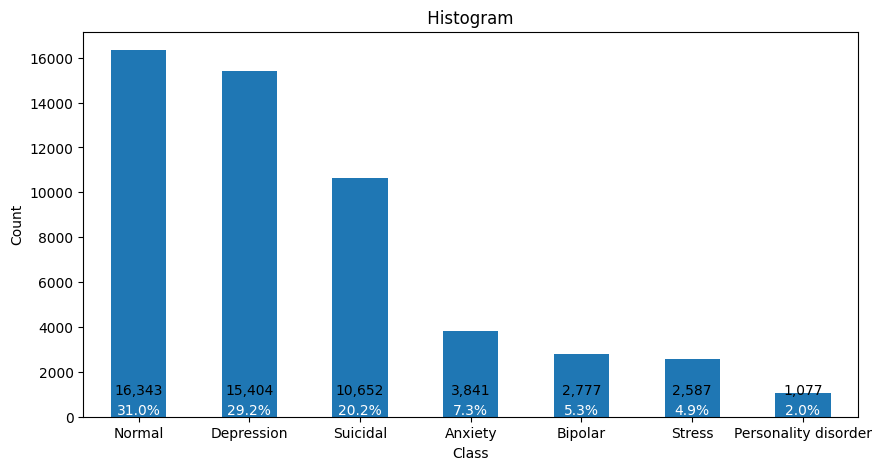

In [6]:
print_class_histogram(df)
plt.show()

In [7]:
# grouping clases merging suicidal and depression
df_grouped = df.copy()
df_grouped.loc[df.status == 'Normal','status'] = 'normal'
df_grouped.loc[df.status == 'Depression','status'] = 'depression'
df_grouped.loc[(df.status == 'Suicidal') ,'status'] = 'depression'
df_grouped.loc[(df.status == 'Anxiety') | (df.status == 'Stress'),'status'] = 'other'
df_grouped.loc[(df.status == 'Bipolar') |(df.status == 'Personality disorder') ,'status'] = 'other'

df_grouped['status_factorized'] = df_grouped.status.factorize()[0]
label_dictionary = df_grouped.status.factorize()[1]

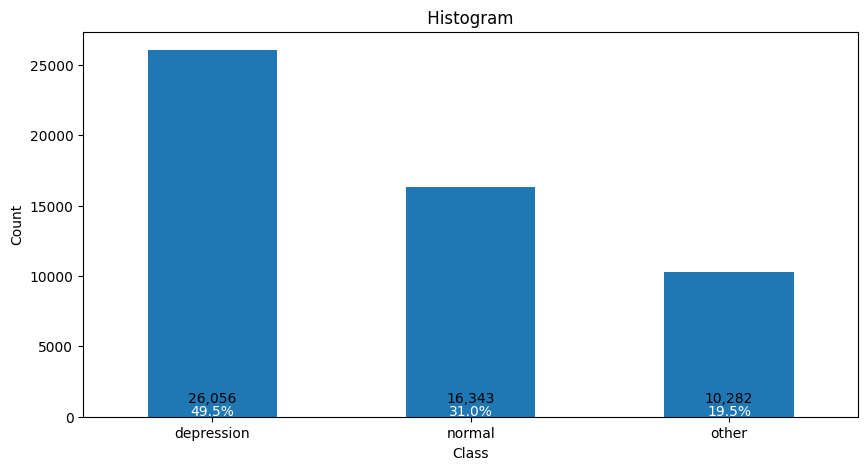

In [8]:
print_class_histogram(df_grouped)
plt.show()

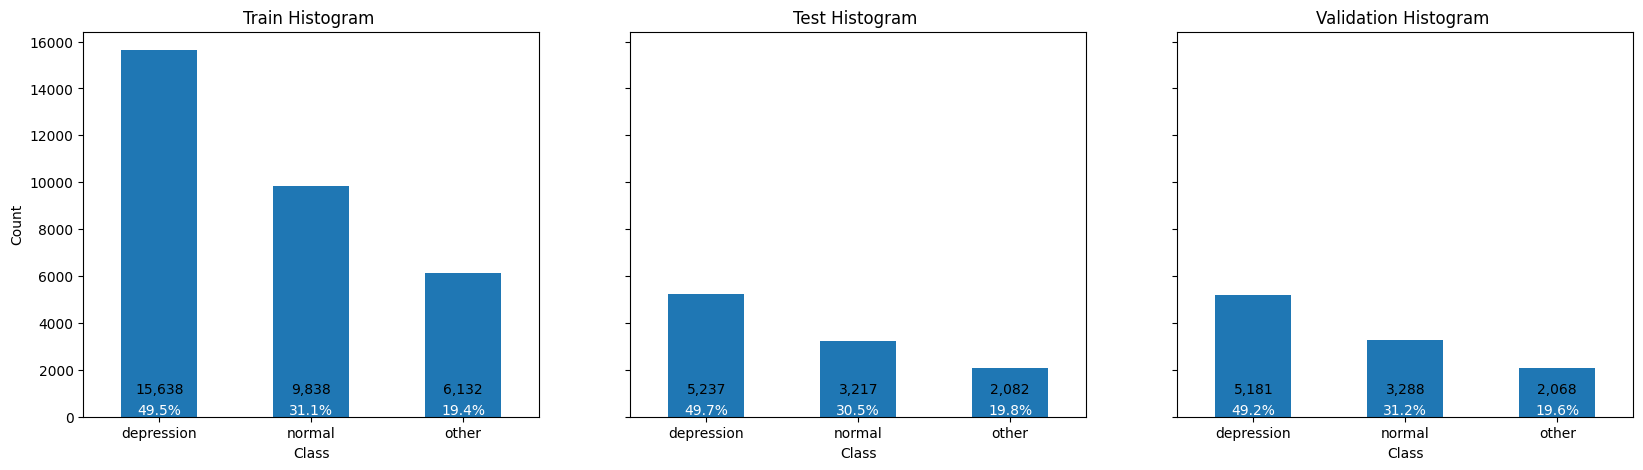

In [9]:
# Split data set into train, test, and validation

train_df, test_df = train_test_split(df_grouped, test_size=0.4, random_state=50)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=50)

# Train data analysis
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey =  True)
print_class_histogram(train_df, "Train", ax = ax[0])
print_class_histogram(test_df, "Test", ax = ax[1])
print_class_histogram(val_df, "Validation", ax = ax[2])
plt.show()


In [10]:
# Length of the statements measured in Number of tokens
train_df.statement.str.split().apply(lambda x: len(x)).describe(percentiles = [0.25, 0.5, 0.75, .85, 0.9, .95, 0.99])

,statement
count,31608.000000
mean,112.119558
std,158.674468
min,1.000000
25%,15.000000
50%,62.000000
75%,148.000000
85%,218.000000
90%,275.000000
95%,389.650000


In [11]:
# Data Processing and Vectorization
# Define variables
max_len = 390 # 726 for 99% of the statements, 390 for 95%
vocab_size = 1000

# Seting variables for training X and y
train_data = train_df.statement.values
train_labels = train_df.status.values

text_vecorization = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                                      output_sequence_length = max_len,
                                                      output_mode= "int",
                                                      pad_to_max_tokens = True,
                                                      standardize = "lower_and_strip_punctuation"
                                                      )
text_vecorization.adapt(train_data)
vocabulary = text_vecorization.get_vocabulary()

In [12]:
print(f"Train data Shape  : {train_data.shape}")
print(f"Vocabulary size   : {text_vecorization.vocabulary_size()}")
print(f"Vocabulary top 20 : {vocabulary[:20]}")
print(f"Vocabulary last 20: {vocabulary[-20::-1]}")

Train data Shape  : (31608,)
Vocabulary size   : 1000
Vocabulary top 20 : ['', '[UNK]', 'i', 'to', 'and', 'the', 'my', 'a', 'of', 'it', 'not', 'is', 'me', 'have', 'that', 'am', 'in', 'do', 'but', 'for']
Vocabulary last 20: ['waking', 'busy', 'immediately', 'normally', 'guilt', 'till', 'ptsd', 'experiencing', '23', 'weed', 'ampx200b', 'comfortable', 'proud', 'seemed', 'eye', 'posting', 'aware', 'gonna', 'planning', 'tips', '16', 'anywhere', 'internet', 'mum', 'cat', 'joy', 'space', 'symptom', 'neck', 'running', 'stable', 'student', 'gives', 'extreme', 'notice', 'questions', 'hanging', 'killed', 'mania', 'themselves', 'funny', 'trouble', 'blame', 'step', 'fake', 'insurance', 'women', 'wont', 'worrying', 'degree', 'na', 'adult', 'process', 'amazing', 'unable', 'medical', 'ruined', 'exactly', 'avoid', '100', 'existence', 'asleep', 'period', 'related', 'toxic', 'relate', 'waste', 'youre', 'word', 'becoming', 'manage', 'sent', 'straight', 'anger', 'level', 'lie', 'perfect', 'honest', 'escape

In [13]:
# Define the vectorized datasets for training, validation and test.

train_data_v = text_vecorization(train_data)
val_data_v = text_vecorization(val_df.statement.values)
test_data_v = text_vecorization(test_df.statement.values)
train_labels_v = train_df.status_factorized.values
val_labels_v = val_df.status_factorized.values
test_labels_v = test_df.status_factorized.values

In [14]:
# Support Class to calculate the mask
class MyMask(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.math.not_equal(inputs, 0)


# Class to build the Positional Embedding layer from "Deep Learning with Python" - Second Edition, Chollet, Listing 11.24
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(
            input_dim=input_dim, output_dim=output_dim
        )
        self.position_embeddings = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return MyMask()(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config



# Class to build the Transformer Encoder layer from "Deep Learning with Python" - Second Edition, Chollet, Listing 11.21
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def compute_mask(self, inputs, mask=None):
        # Ensure this propagates the mask
        return mask

# Funcion to build a transformer model using the classes created above
def build_Transformer_model(sequence_length,    # Length of the sequences of words (max_len = 390)
                            vocab_size,         # Vocabulary Size (vocab_size = 1000)
                            embedding_dim,      # Embedding dimensions (32)
                            dense_dim,          # number of units in the attention layer (32)
                            num_heads,          # number of heads in the attention layer (4)
                            dropout_rate,       # proportion of dropped threads
                            learning_rate       # learning rate used by the optimizer
                            ):
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)
    embedding = PositionalEmbedding(
        sequence_length = sequence_length,  # The length of the statements
        input_dim = vocab_size,             #Size of the vocabulary
        output_dim = embedding_dim  # Dimensions of the dense embedding
        )(inputs)
    x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(embedding)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')


In [15]:
# Transformers
num_heads = 5 # self attention heads
# max_len = the length of the statemetns defined above
# vocab_size = size of the vocabulary vector, defined above
embedding_dim = 128 # number of dimensions of the embedding
dense_dim = 256 # number of units in the dense layer of the transformer encoder
dropout_rate = 0.2 # dropout percent after the transformer
batch_size = 32
epochs = 10
learning_rate = 0.002

Transformer_model = build_Transformer_model(sequence_length = max_len,
                                            vocab_size = vocab_size,
                                            embedding_dim = embedding_dim,
                                            dense_dim = dense_dim,
                                            num_heads = num_heads,
                                            dropout_rate = dropout_rate,
                                            learning_rate = learning_rate)
print(Transformer_model.summary())

# adding early stopping
callbacks = [keras.callbacks.ModelCheckpoint("Transformer_model.keras", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
             ]

history = Transformer_model.fit(train_data_v,
                         train_labels_v,
                         epochs=epochs,
                         batch_size= batch_size,
                         validation_data=(val_data_v,val_labels_v),
                         callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 128)      │        177,920 │ input_layer[0][0]      │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ my_mask (MyMask)          │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │        396,160 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ my_mask[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ transformer_encoder[0… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            516 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 574,596 (2.19 MB)

 Trainable params: 574,596 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


988/988 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8247 - loss: 0.5100 - val_accuracy: 0.9001 - val_loss: 0.2995
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9070 - loss: 0.2665 - val_accuracy: 0.9017 - val_loss: 0.2894
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9188 - loss: 0.2335 - val_accuracy: 0.9030 - val_loss: 0.3140
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9251 - loss: 0.2186 - val_accuracy: 0.9040 - val_loss: 0.3054
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9266 - loss: 0.2061 - val_accuracy: 0.9074 - val_loss: 0.2991
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9359 - loss: 0.1877 - val_accuracy: 0.9077 - val_loss: 0.3095
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9404 - loss: 0.1733 - val_accuracy: 0.9062 - val_loss: 0.2957
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9439 - loss: 0.1636 - val_accurac

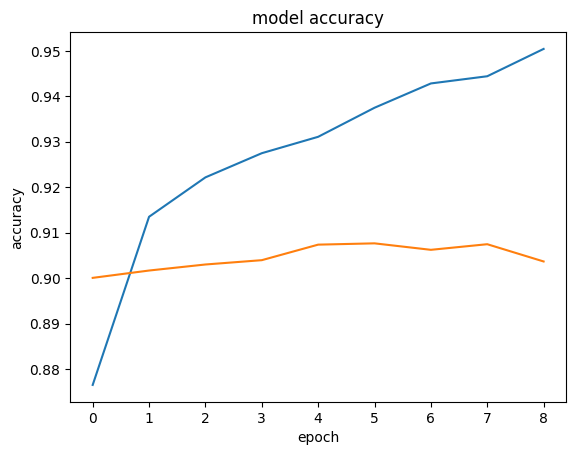

In [16]:
plot_history(history)


In [17]:
# Hyperparameter Optimization

# Define a function to build the model for Keras Tuner
def build_Transformer_model_tuned(hp):
    num_heads = hp.Int("num_heads", min_value=4, max_value=8, step=1)
    dense_dim = hp.Int("dense_dim", min_value=128, max_value=320, step=64)
    dropout_rate = hp.Float("dropout_rate", min_value = 0.2, max_value = 0.6, step = 0.2)
    embedding_dim = hp.Int("embedding_dim", min_value= 50, max_value= 200, step = 50)
    learning_rate = 0.002 #

    # Build the Transformer model with hyperparameters
    Transformer_model = build_Transformer_model(
        sequence_length=max_len,
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        dense_dim=dense_dim,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
    )
    return Transformer_model

# Instantiate a tuner
tuner = kt.Hyperband(
    build_Transformer_model_tuned,
    objective="val_accuracy",  # Optimize for validation accuracy
    max_epochs=10,  # Number of epochs per trial
    factor=3,  # Reduction factor for the number of models per bracket
    directory="my_dir",
    project_name="transformer_Agg_hyperparameter_tuning",
)

# Search for the best hyperparameters
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3),
]

tuner.search(
    train_data_v,
    train_labels_v,
    validation_data=(val_data_v, val_labels_v),
    callbacks=callbacks,
    batch_size=32,
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of heads is {best_hps.get('num_heads')},
The optimal dense layer dimension is {best_hps.get('dense_dim')}.
The optimal dropout_rate is {best_hps.get('dropout_rate')}.
The optimal embedding dimensions is {best_hps.get('embedding_dim')}.
""")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_data_v,
    train_labels_v,
    validation_data=(val_data_v, val_labels_v),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
)


Trial 30 Complete [00h 11m 38s]
val_accuracy: 0.9061402678489685

Best val_accuracy So Far: 0.9134478569030762
Total elapsed time: 01h 40m 41s

The optimal number of heads is 4,
The optimal dense layer dimension is 192.
The optimal dropout_rate is 0.4.
The optimal embedding dimensions is 50.

Epoch 1/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7739 - loss: 0.6333 - val_accuracy: 0.9014 - val_loss: 0.2848
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9002 - loss: 0.2842 - val_accuracy: 0.9091 - val_loss: 0.2701
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9121 - loss: 0.2550 - val_accuracy: 0.9079 - val_loss: 0.2717
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9202 - loss: 0.2321 - val_accuracy: 0.9014 - val_loss: 0.2900
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9253 - loss: 0.2187 - val_accuracy: 0.9099 - val_loss: 0.2908
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - 

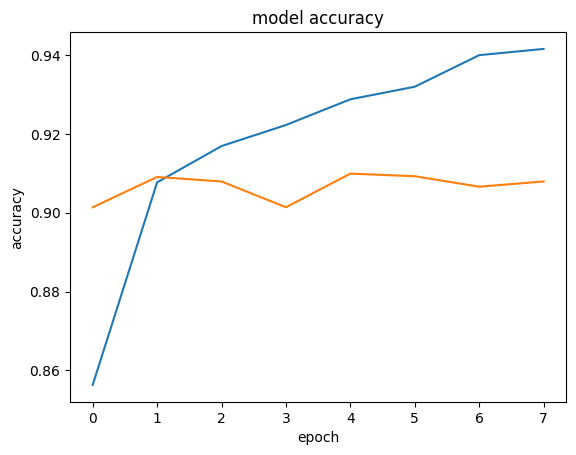

In [18]:
plot_history(history)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels_v, np.argmax(best_model.predict(test_data_v), axis=-1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_dictionary)


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


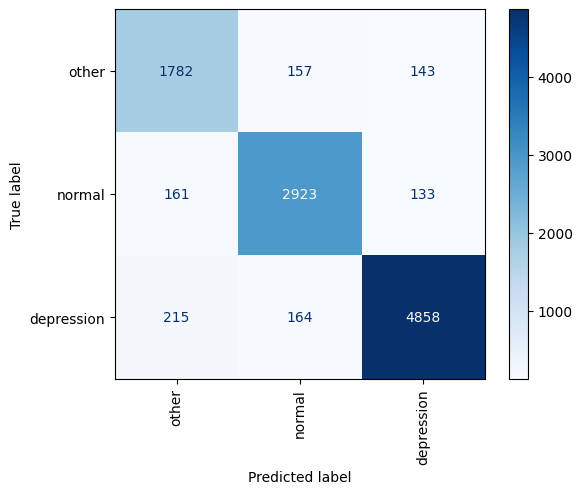

In [20]:
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()